<a href="https://colab.research.google.com/github/halalshammari/student-performance-ml/blob/main/experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import kagglehub
import os
import pandas as pd
import numpy as np

KaggleHub downloads a dataset as a **folder**.
OS helps you build the exact path to a **specific file** inside that folder.
Pandas reads that file.




In [8]:
# Download latest version
path = kagglehub.dataset_download("neurocipher/student-performance")

print("Path to dataset files:", path)
os.listdir(path) #to find the files INSIDE the folder, so you can prepare it for Pandas to read it

Using Colab cache for faster access to the 'student-performance' dataset.
Path to dataset files: /kaggle/input/student-performance


['StudentPerformance.csv']

In [10]:
csv_path = os.path.join(path, 'StudentPerformance.csv')
df_student = pd.read_csv(csv_path)

Now that we have read the dataset properly, we can start **EDA**.

In [11]:
df_student.info() #we don't have any null values, we have a categorical column, everything else is numbers

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


We have one categorical column, we need to encode it, and we have numerical
columns, we need to check the range and see if we need scaling.

Since the target column is a numerical value that is not discrete, this is a
**regression problem**

In [17]:
df_student.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [18]:
df_student.describe()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,6.530600,4.583300,55.224800
std,2.589309,17.343152,1.695863,2.867348,19.212558
min,1.000000,40.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

This import is for plotting purposes, the second line is to force the plots to be inside of the notebook instead of external windows

Now we wanna plot:
1. Target distribution
2. 2–3 important features vs target

We do this to visually check for imbalances (categorical) or outlires and stuff (regression)

# Target distribution
The goal is to check for **skewness** and **outliers**

Heavy skew can dominate loss functions (MSE especially)
And if my target has a long tail, the model might focus on it instead, because loss functions care about magnitude, not considering frequency.

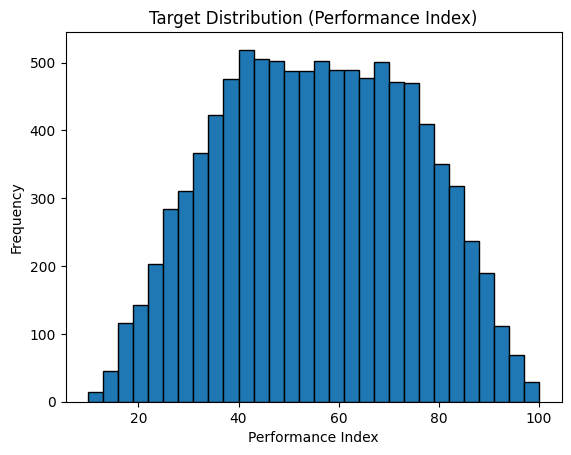

In [22]:
df_student['Performance Index'].hist(bins=30, edgecolor='black')

plt.title(f"Target Distribution ({'Performance Index'})")
plt.xlabel('Performance Index')
plt.ylabel("Frequency")
plt.grid(False)

plt.show()

This is an ideal target for standard regression losses (MSE, RMSE, MAE). The histogram is roughly symmetric.

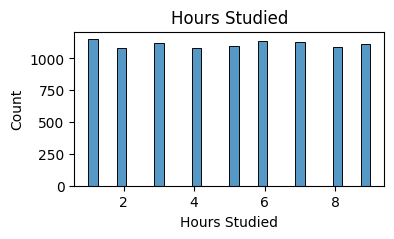

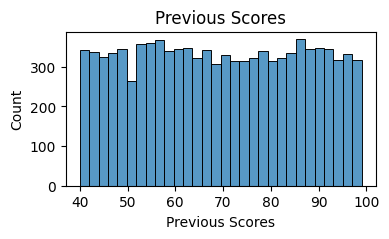

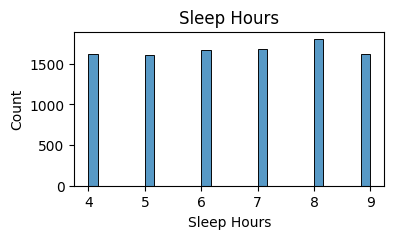

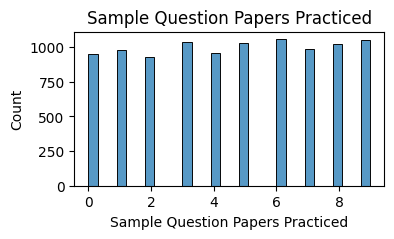

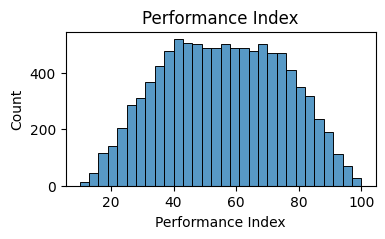

In [21]:
num_cols = df_student.select_dtypes(include=np.number).columns

for col in num_cols:
    plt.figure(figsize=(4,2))
    sns.histplot(df_student[col].dropna(), bins=30)
    plt.title(col)
    plt.show()

Everything is fairly symmetric, so I don't expect weird behaviour.
Main questions to ask:
1. outliers? As in heavy tails and single bars away from the others.


I still need a plot for the categorical column Vs. the target

<Axes: xlabel='Extracurricular Activities', ylabel='Performance Index'>

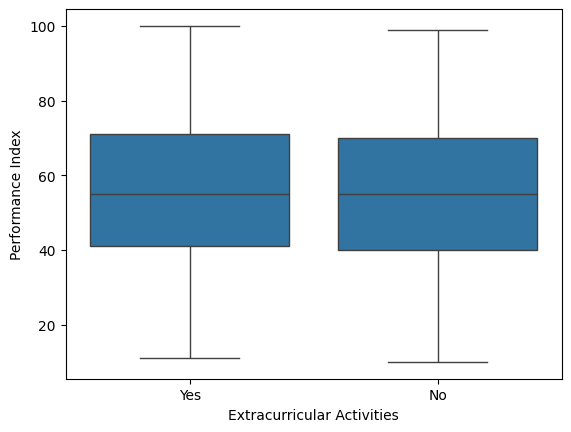

In [23]:
sns.boxplot(x='Extracurricular Activities', y='Performance Index', data=df_student)

Students with extracurricular activities do not have meaningfully different performance than those without — at least in isolation.

I wanna check if it has any affects on study hours.

<Axes: xlabel='Extracurricular Activities', ylabel='Hours Studied'>

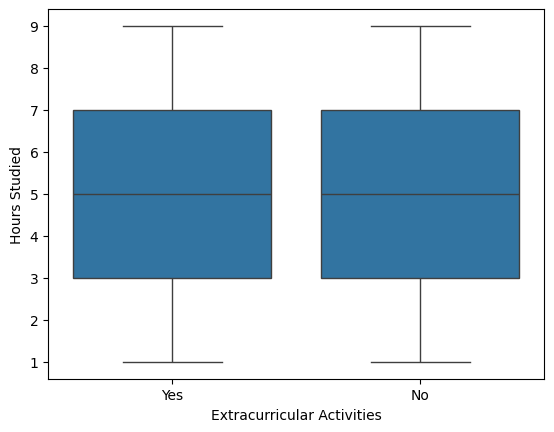

In [25]:
sns.boxplot(x='Extracurricular Activities', y='Hours Studied', data=df_student)

No visible contribuition, but I will let models decide.
I will train a tree model and a liner regression model.
We don't have any missing values, so for this problem, no data cleaning.
Now, I need to start **encoding** and checking if I need **scaling**.

In [27]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso
# from sklearn.metrics import mean_absolute_error, mean_squared_error

In [29]:
# categorical_col = ['Extracurricular Activities']
df_clean = df_student.copy()
le = LabelEncoder()
df_clean['Extracurricular Activities'] = le.fit_transform(df_clean['Extracurricular Activities']) #write them explicitly, and if more than one, use a for loop
df_clean.head()


,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,1,9,1,91.0
1,4,82,0,4,2,65.0
2,8,51,1,7,2,45.0
3,5,52,1,5,2,36.0
4,7,75,0,8,5,66.0


Brainstorming engineered features:
- **Effort efficiency**: performance / hours studied
- **Practice intensity**: sample questions / hours studied
- **Lifestyle balance**: sleep hours / hours studied

In [32]:
df_clean['Effort efficiency'] = df_clean['Performance Index'] / df_clean['Hours Studied']
df_clean['Practice intensity'] = df_clean['Sample Question Papers Practiced'] / df_clean['Hours Studied']
df_clean['Lifestyle balance'] = df_clean['Sleep Hours'] / df_clean['Hours Studied']
df_clean.head()



,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index,Effort efficiency,Practice intensity,Lifestyle balance
0,7,99,1,9,1,91.0,13.000000,0.142857,1.285714
1,4,82,0,4,2,65.0,16.250000,0.500000,1.000000
2,8,51,1,7,2,45.0,5.625000,0.250000,0.875000
3,5,52,1,5,2,36.0,7.200000,0.400000,1.000000
4,7,75,0,8,5,66.0,9.428571,0.714286,1.142857


Now, we **prepare** data for modeling.
We need to:
- Split
- Scale if needed, and remember to never scale the target

In [33]:
features = df_clean.columns.drop('Performance Index')  # DON'T SCALE THE TARGET
print(features)


Index(['Hours Studied', 'Previous Scores', 'Extracurricular Activities',
       'Sleep Hours', 'Sample Question Papers Practiced', 'Effort efficiency',
       'Practice intensity', 'Lifestyle balance'],
      dtype='object')


In [34]:
df_clean[features].describe()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Effort efficiency,Practice intensity,Lifestyle balance
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,0.494800,6.530600,4.583300,15.865786,1.443633,2.072818
std,2.589309,17.343152,0.499998,1.695863,2.867348,13.510745,1.720765,1.929847
min,1.000000,40.000000,0.000000,4.000000,0.000000,3.250000,0.000000,0.444444
25%,3.000000,54.000000,0.000000,5.000000,2.000000,7.833333,0.428571,0.875000
50%,5.000000,69.000000,0.000000,7.000000,5.000000,11.111111,1.000000,1.333333
75%,7.000000,85.000000,1.000000,8.000000,7.000000,18.000000,1.666667,2.333333
max,9.000000,99.000000,1.000000,9.000000,9.000000,79.000000,9.000000,9.000000


There is a range issue, scaling won't hurt, do it anyway. But seperate the data first so you'll keep **y** safe.

In [35]:
X = df_clean[features]
y = df_clean['Performance Index']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)

# Scale features - fit on train, transform both. We do this to prevent data leakage from the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_val)

Now that we seperated everything, and prepared our data, I wanna implement random forest and ridge and lasso regression.

I wanna try different models with different hyperparameters, so we have two layers of looping:
1. Accross models: Ridge, Lasso, Random forests
2. Accross hyperparameters for EACH model

So, a clean mental split is:
Model choice, hyperparameter choice, KFold evaluation

We can either loop manually, or use GridSearchCV (industry-standard)

GridSearchCV already:
- Loops over hyperparameters
- Runs K-Fold internally
- Prevents data leakage
- Tracks best model automatically


In [40]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [42]:
#One dictionary for the model, internal dictionary for model and params, another internal dictionary for different params
param_grids = {
    "Ridge": {
        "model": Ridge(max_iter=10000),
        "params": {
            "alpha": [0.01, 0.1, 1.0, 10.0, 100.0]
        }
    },
    "Lasso": {
        "model": Lasso(max_iter=10000),
        "params": {
            "alpha": [0.001, 0.01, 0.1, 1.0]
        }
    },
    "RandomForest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            "n_estimators": [100, 200, 500],
            "max_depth": [None, 5, 10],
            "min_samples_split": [2, 5]
        }
    }
}

#Loop over models
results = {}
# 'name' is the keys (Ridge, Lasso, Random Forest) and 'config' is the values associated with them
for name, config in param_grids.items():
    grid = GridSearchCV(
        estimator=config["model"],
        param_grid=config["params"],
        cv=5,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1
    )

    grid.fit(X_train_scaled, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    results[name] = {
        "best_params": grid.best_params_,
        "test_rmse": rmse
    }

#Inspect results




{'Ridge': {'best_params': {'alpha': 1.0}, 'test_rmse': np.float64(1.9717473558837308)}, 'Lasso': {'best_params': {'alpha': 0.001}, 'test_rmse': np.float64(1.9718901824132695)}, 'RandomForest': {'best_params': {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}, 'test_rmse': np.float64(0.39153303819728924)}}


Define a function to print the results in a more readable way

In [44]:
def print_model_results(results):
    for model_name, model_result in results.items():
        print("=" * 50)
        print(f"Model: {model_name}")
        print(f"Best Parameters: {model_result['best_params']}")
        print(f"Test RMSE: {model_result['test_rmse']:.4f}")

In [45]:
print_model_results(results)

Model: Ridge
Best Parameters: {'alpha': 1.0}
Test RMSE: 1.9717
Model: Lasso
Best Parameters: {'alpha': 0.001}
Test RMSE: 1.9719
Model: RandomForest
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}
Test RMSE: 0.3915


This shows that the best model is the random forest, and it shows the best parameters. This helps us to decide which model will generalize best.
But does it mean that the validation set is compromised? Can we still use it? Or did it serve its purpose already and now we only care about fitting?

Now, we freeze the best configuration and retrain it again and this is the FINAL model and the one we deploy.
BUT,
we also need to compare our results with a baseline, for this case, the mean. If our model can't beat it, it basically did nothing, we were better off just guessing the mean everytime.

In [46]:
# We train a final model with the best config we found
final_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    random_state=42
)

final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_val)
rmse_model = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Random Forest RMSE: {rmse_model:.4f}")

Random Forest RMSE: 0.3898


In [47]:
# Now we compare what we just got with the baseline to check if our model beat it
baseline_pred = np.full_like(y_val, y_train.mean(), dtype=float) #we are saying, create a thing called baseline_pred that has the shape of y_val but filled with the mean of y_train
#And make sure you only use y_train.mean(), never use y_val


rmse_baseline = np.sqrt(mean_squared_error(y_val, baseline_pred))
print(f"Baseline RMSE (mean predictor): {rmse_baseline:.4f}")

Baseline RMSE (mean predictor): 19.2738


# WE'RE DONE!!
Models are answers to questions.
Can we predict student performance better than a naive mean predictor using these features?
**Yes, very strongly.**


Now, I wanna see what were the most important features.

In [48]:

importances = final_model.feature_importances_
feature_importance_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)

feature_importance_df

,feature,importance
1,Previous Scores,0.840580
0,Hours Studied,0.137890
5,Effort efficiency,0.020468
3,Sleep Hours,0.000413
4,Sample Question Papers Practiced,0.000250
6,Practice intensity,0.000176
7,Lifestyle balance,0.000173
2,Extracurricular Activities,0.000051
